# Chatbots - Classificação de Tweets (Tweet Classification)

> Faça um classificador que leia os tweets do arquivo "Tweets.csv" e classifique sentenças fornecidas pelo usuário como "Positiva", "Neutra" e "Negativa".

**Requisitos:**

1.   Ler o arquivo "Tweets.csv";
2.   Utilizar o processo de Tokenization;
3.   Utilizar o processo de Bag of Words;
4.   Classificar usando Bayes;
4.   Utilizar as colunas "airline_sentiment" e ;

> Fonte dataset: https://raw.githubusercontent.com/gomesfg/chatbots/ceba8bfa8c26320457ffb6559d02766e0711f802/tweet_classification/Tweets.csv

---



In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Importando arquivo com os tweets
tweets = pd.read_csv('https://raw.githubusercontent.com/gomesfg/chatbots/ceba8bfa8c26320457ffb6559d02766e0711f802/tweet_classification/Tweets.csv')

# Mostrar dados do arquivo
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Frequencia de sentimentos

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


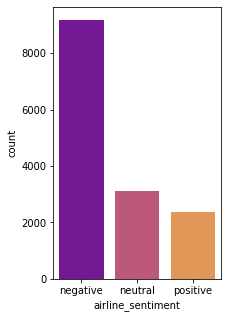

In [23]:
plt.figure(figsize=(3,5))
sns.countplot(tweets['airline_sentiment'], order =tweets.airline_sentiment.value_counts().index,palette= 'plasma')
plt.show()

# Word Cloud

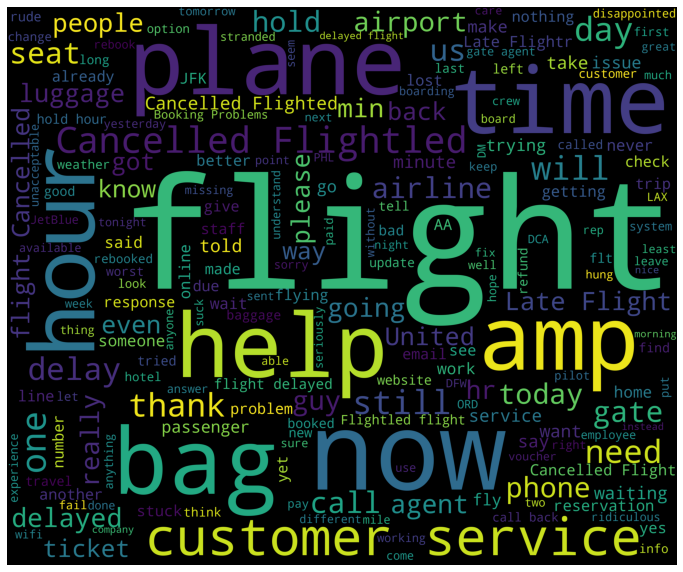

In [26]:
new_df=tweets[tweets['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# StopWords

In [16]:
stop=['I',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',"it's"]
tweets['text']=tweets['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
tweets.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica didn't today... Must mean need ...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica really aggressive to blast obno...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and a really big bad thing abou...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# "Tokenization" e "Bag of Words"

In [17]:
def get_positive_words_dataframe():
    positive_tweets = tweets[tweets.airline_sentiment == 'positive']
    return positive_tweets.text.str.split(expand=True).stack().value_counts().rename_axis('word').reset_index(name='positive')

def get_negative_words_dataframe():
    negative_tweets = tweets[tweets.airline_sentiment == 'negative']
    return negative_tweets.text.str.split(expand=True).stack().value_counts().rename_axis('word').reset_index(name='negative')

def get_neutral_words_dataframe():
    neutral_tweets = tweets[tweets.airline_sentiment == 'neutral']
    return neutral_tweets.text.str.split(expand=True).stack().value_counts().rename_axis('word').reset_index(name='neutral')

def create_counted_words_dataframe(positive_dataframe, negative_dataframe, neutral_dataframe):
    return positive_dataframe.set_index('word').join(negative_dataframe.set_index('word')).join(neutral_dataframe.set_index('word'))

def fill_na_with_zeros(dataframe):
    for column in dataframe.columns:
        dataframe[column].fillna(0, inplace=True)

In [19]:
positive_dataframe = get_positive_words_dataframe()
negative_dataframe = get_negative_words_dataframe()
neutral_dataframe = get_neutral_words_dataframe()

dataframe = create_counted_words_dataframe(positive_dataframe, negative_dataframe, neutral_dataframe)
fill_na_with_zeros(dataframe)
#positive_dataframe
dataframe

,positive,negative,neutral
word,,,
the,924,3929.0,928.0
to,923,5966.0,1646.0
for,658,2665.0,598.0
@SouthwestAir,548,1157.0,639.0
@JetBlue,503,893.0,578.0
...,...,...,...
GUYS,1,1.0,0.0
#616,1,0.0,0.0
scheme,1,1.0,0.0


# Classificação utilizando o método de Bayes

In [20]:
def classify_phrase_using_bayes(phrase, dataframe):
    display(phrase)
    
    moods = ['positive', 'negative', 'neutral'];
    for mood in moods:
        probability = calculate_bayes(phrase, dataframe, mood)
        display(mood+": "+str(probability))
    

def calculate_bayes(phrase, dataframe, mood):
    A_probability = get_mood_probability(dataframe, mood)
    B_probability = get_phrase_probability(phrase, dataframe, mood)
    B_to_A_probability = get_B_to_A_probability(phrase, dataframe, mood)
    
    A_to_B_probability = B_to_A_probability * A_probability / B_probability
    
    return A_to_B_probability

def get_mood_probability(dataframe, mood):
    total_mood_resgisters = get_total_registers_from_mood(mood)
    total_registers = get_total_registers_from_dataframe(dataframe)
    return total_mood_resgisters/total_registers

def get_phrase_probability(phrase, dataframe, mood):
    words_occurrences = 0;
    words = phrase.split()
    for word in words:
        words_occurrences += get_total_of_occurrence_of_word(word, dataframe)

    total_registers = get_total_registers_from_dataframe(dataframe)
        
    return words_occurrences/total_registers

def get_B_to_A_probability(phrase, dataframe, mood):
    words_occurrences = 0;
    words = phrase.split()
    for word in words:
        words_occurrences += dataframe.loc[word][mood]

    total_mood = get_total_registers_from_mood(mood)
        
    return words_occurrences/total_mood
    
def get_total_registers_from_mood(mood):
    return dataframe[mood].sum()

def get_total_of_occurrence_of_word(word, dataframe):
    return dataframe.loc[word].sum();

def get_total_registers_from_dataframe(dataframe):
    total_positives = get_total_registers_from_mood('positive')
    total_negatives = get_total_registers_from_mood('negative')
    total_neutrals = get_total_registers_from_mood('neutral')
    return total_positives+total_negatives+total_neutrals 

In [21]:
phrase_to_test = 'love flying'
classify_phrase_using_bayes(phrase_to_test, dataframe)

'love flying'

'positive: 0.32876712328767127'

'negative: 0.43607305936073065'

'neutral: 0.23515981735159822'